# Milestone 4

In [3]:
# Imports
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

## Table of Contents

1. Problem Statement and Research Question
2. Explore and Visualize Data
3. Baseline Model
4. Results Interpretation 
5. Final Model Pipeline



## 1. Problem Statement and Research Question


### 1a. Background Information

Voter turnout reflects the health of a democratic system, measuring the participation of its members in the electoral process.  However, it is widely documented that voter turnout varies significantly across demographic groups such as age, race, education, and income. Research finds that nonvoters are more likely to be younger, identify as non-White, have low education, and come from low income households ([Pew Research Group, 2023](https://www.pewresearch.org/politics/2023/07/12/voter-turnout-2018-2022/)). Further understanding these patterns is crucial for identifying barriers to participation and designing policies to improve turnout ([MIT, 2021](https://electionlab.mit.edu/research/voter-turnout)).

This project explores the predictive power of voter characteristics on voter turnout for the 2020 presidential election in the state of Massachusetts. By leveraging Census Block Group data, this study aims to uncover localized patterns that aggregate county or state-level studies ([Ansolabehere et al., 2024](https://hdsr.mitpress.mit.edu/pub/0c5ylgo1/release/2)) or individual-level studies ([Kim, 2024](https://link.springer.com/article/10.1007/s11109-022-09816-z#Sec14)) may overlook.

### 1b. Main Question

How do different voter characteristics influence voter turnout in Massachusetts?

## 2. Explore and Visualize Data

### 2a. Information on the Data

To answer this question, we use voter turnout data at the Census Block level sourced from L2 Data and Redistricting Data Hub.

We applied several processing steps which included:
1. Dropped observations without Census Block IDs that were instead aggregated to the County level (73,811 or ~1.60% of total voters). Disaggregating these observations necessitated the assumption that demographic characteristics are uniformly distributed across the County, which is false.
2. Aggregated the Census Block data to the Census Block Group level to reduce the high variance of registered voter counts in each observation.
3. Converted most demographic predictors from counts of voters to proportion of voters. We did this to account for differences in the number of voters that lived in each Census Block Group (a Census Block Group in a city will likely have a higher voter count than a Census Block Group in rural Massachusetts).

Our response variable is the proportion of registered voters that voted in the 2020 presidential election, denoted as `2020_turnout_pct`.

Our predictors include the total number of voters registered, mean household income, and the proportion of people with specific characteristics such as age; ethnicity; party affiliation; and language.

In [4]:
# Read in the final data
voter_gdf = gpd.read_file("../data/block_groups.geojson")

In [5]:
# Group the variables together
registered = ["total_reg"]
income = ["mean_hh_income"]
age = ["age_18_19", "age_20_24", "age_25_29", "age_30_34", "age_35_44", 
       "age_45_54", "age_55_64", "age_65_74", "age_75_84", "age_85over"]
gender = [ "gender_m", "gender_f", "gender_unknown"] 
party = ["party_npp", "party_dem", "party_rep", "party_lib", "party_grn", 
         "party_con", "party_ain", "party_scl", "party_oth"]
ethnicity1 = ["eth1_eur", "eth1_hisp", "eth1_aa",
                "eth1_esa", "eth1_oth", "eth1_unk"]
languages = ["lang_english", "lang_spanish", "lang_portuguese",
             "lang_chinese", "lang_italian", "lang_vietnamese", 
             "lang_other", "lang_unknown"]
predictors = [*registered, *income, *age, *gender, *party, *ethnicity1, *languages]

In [27]:
# Define X and y 
X = voter_gdf.copy()

### 2b. Data Visualization

"Conduct exploratory data analysis to understand the underlying patterns and relationships in the data. Visualizations can be helpful in identifying trends and outliers. Make sure that the EDA you present explains the feature engineering choices you made. Moreover, when we read through your notebook, we expect to understand why you choose the particular baseline model and why you engineer your features the way you did. This section would be a great way to provide your reasoning."

In [ ]:
# Define plotting functions
def plotdist(data, title, column, xlabel, ylabel, annotation_format, annotation_height):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8,6))

    # KDE plot
    sns.kdeplot(data, x=column, linewidth=3, alpha=0.75, ax=ax)

    # Calculate statistics
    median = data[column].median()
    p5 = np.percentile(data[column], 5)
    p95 = np.percentile(data[column], 95)

    # Add vertical lines for statistics
    plt.axvline(x=median, linestyle="--", color="r", linewidth=2, label="Median")
    plt.axvline(x=p5, linestyle=":", color="k", linewidth=2, label="5th percentile")
    plt.axvline(x=p95, linestyle=":", color="k", linewidth=2, label="95th percentile")

    # Annotate statistics on the plot
    y_min, y_max = ax.get_ylim()
    plt.text(median, annotation_height[1] * y_max, annotation_format.format(median), color="r", bbox={"edgecolor":"r", "facecolor":"white", "alpha":0.9}, ha="center")
    plt.text(p5, annotation_height[0] * y_max, annotation_format.format(p5), color="k", bbox={"edgecolor":"k", "facecolor":"white", "alpha":0.9}, ha="center")
    plt.text(p95, annotation_height[2] * y_max, annotation_format.format(p95), color="k", bbox={"edgecolor":"k", "facecolor":"white", "alpha":0.9}, ha="center")

    # Customize axes
    print()
    plt.xticks(ax.get_xticks(), [annotation_format.format(x) for x in ax.get_xticks()])
    plt.xlim(data[column].min(), data[column].max())
    
    # Add the custom legend to the plot
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)

    plt.show()

def plotscatter(data, title, x_column, y_column, xlabel, ylabel, label_format):
    fig,ax = plt.subplots(figsize = (8,6))

    sns.scatterplot(voter_gdf, x=x_column, y=y_column, alpha=0.3)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.xticks(ticks=ax.get_xticks(), labels=[label_format.format(x) for x in ax.get_xticks()])
    plt.grid(alpha=0.3)
    plt.title(title)
    plt.show()

# Plots voter distribution by category via kernel density
def plotKDE(data, title, vars, labels, colors, xlabel):
    fig,ax = plt.subplots(figsize = (8,6))
    legend_elements =[]
    for i in range(len(vars)):
        sns.kdeplot(data, x=vars[i], y='2020_turnout_pct', ax=ax,
                    color=colors[i],
                        alpha=0.3,
                        label=labels[i]
                    )
        legend_elements.append(Line2D([0], [0], color=colors[i], lw=4, label=labels[i]))

    # Add the custom legend to the plot
    plt.legend(handles=legend_elements)
    plt.title(title)
    plt.xlabel(f'Proportion of {xlabel}')
    plt.ylabel('Voter Turnout')
    plt.grid(alpha=0.3)
    plt.show()

#### 2b. i. Distribution of variables

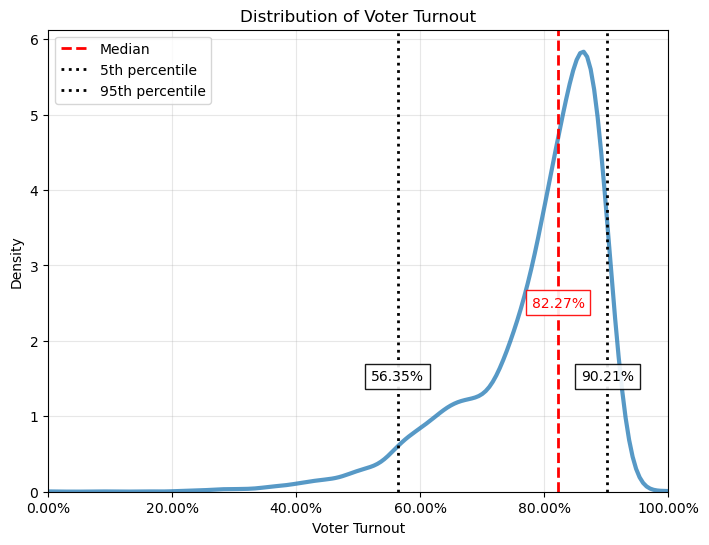

In [111]:
plotdist(X, "Distribution of Voter Turnout", 
         "2020_turnout_pct", "Voter Turnout", "Density",
         "{:.2%}", [0.24,0.4,0.24])

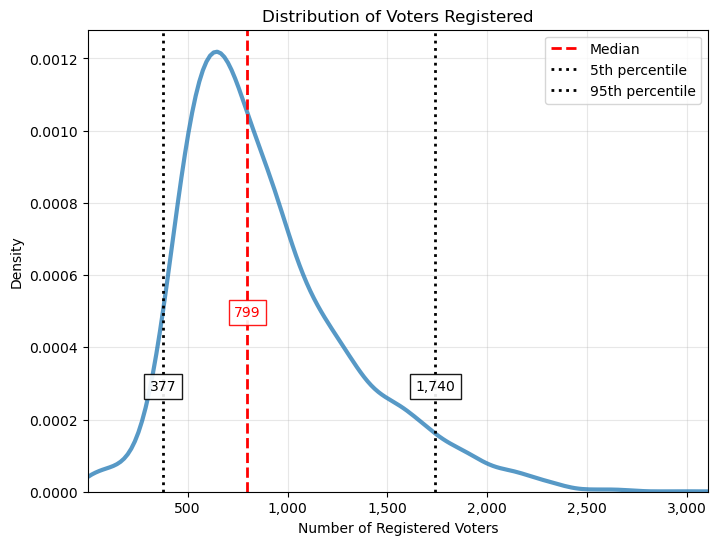

In [112]:
plotdist(X, "Distribution of Voters Registered", 
         "total_reg", "Number of Registered Voters", "Density",
         "{:,.0f}", [0.22,0.38,0.22])

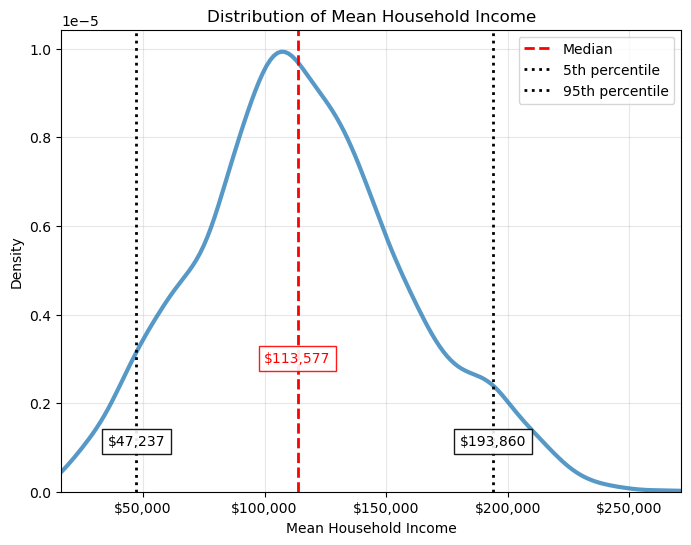

In [123]:
plotdist(X, "Distribution of Mean Household Income", 
         "mean_hh_income", "Mean Household Income", "Density",
         "${:,.0f}", [0.1,0.28,0.1])

#### 2b. ii. Voter Turnout by Party

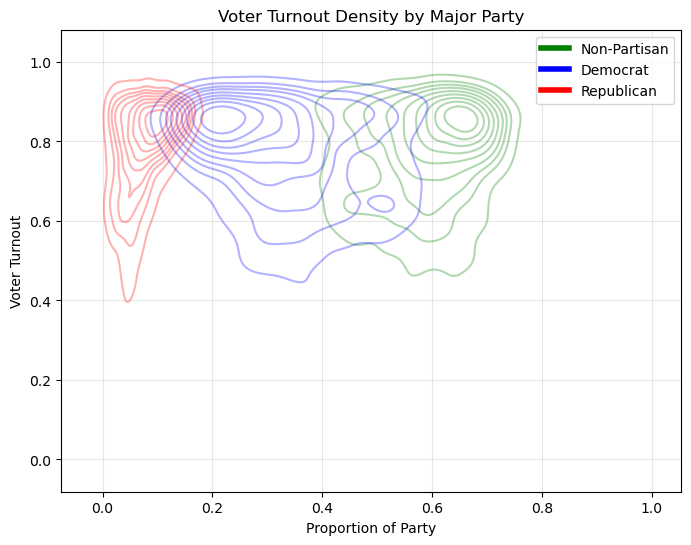

In [33]:
plotKDE(X, 'Voter Turnout Density by Major Party',
        ['party_npp', 'party_dem', 'party_rep'],
        ['Non-Partisan', 'Democrat', 'Republican'],
        ['green','blue','red'],
        'Party')

#### 2b. iii. Voter Turnout by Income

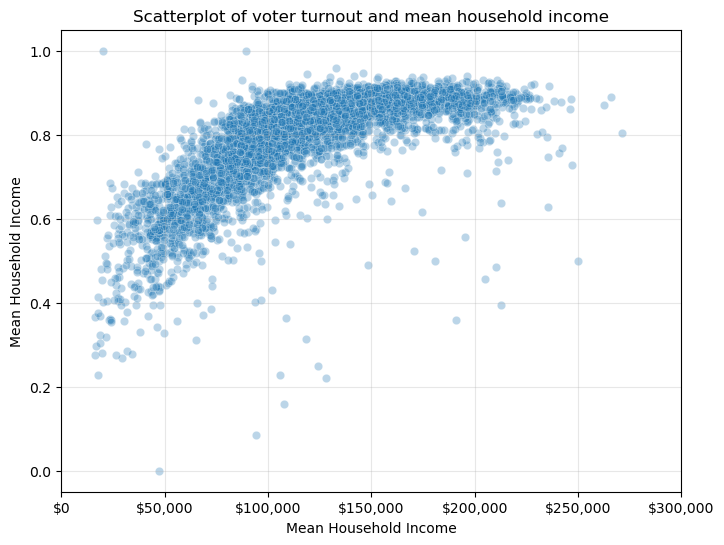

In [128]:
plotscatter(X, "Scatterplot of voter turnout and mean household income", 
            "mean_hh_income", "2020_turnout_pct", 
            "Mean Household Income", "Voter Turnout", "${:,.0f}")

#### 2b. iv. Voter Turnout by Ethnicity

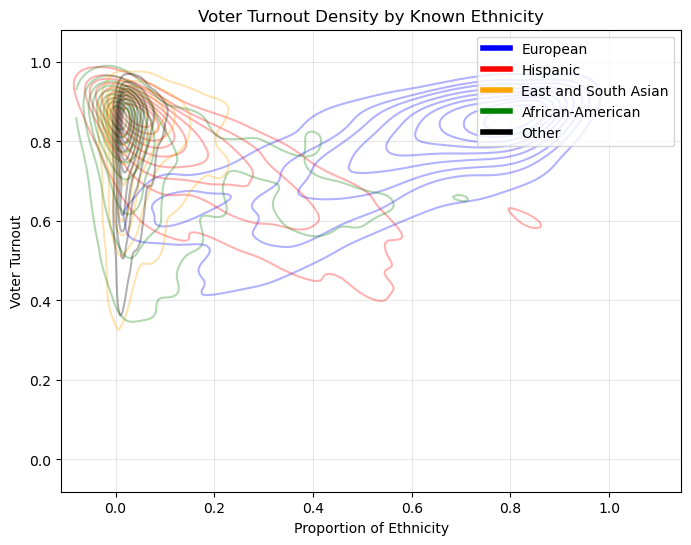

In [35]:
plotKDE(X, 'Voter Turnout Density by Known Ethnicity',
        ['eth1_eur','eth1_hisp', 'eth1_esa', 'eth1_aa','eth1_oth'],
        ['European', 'Hispanic',  'East and South Asian', 'African-American',  'Other'],
        ['blue','red', 'orange', 'green', 'black', 'gray'],
        'Ethnicity')

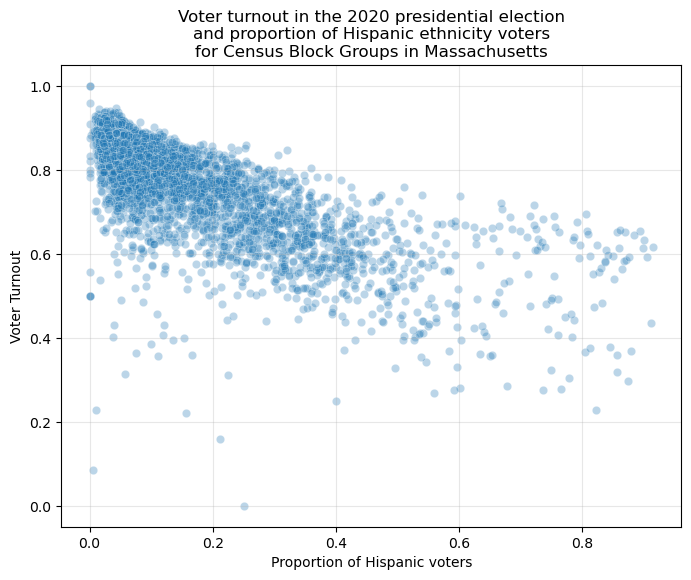

In [12]:
fig,ax = plt.subplots(figsize = (8,6))

sns.scatterplot(voter_gdf, x="eth1_hisp", y="2020_turnout_pct", alpha=0.3)
plt.xlabel("Proportion of Hispanic voters")
plt.ylabel("Voter Turnout")
plt.grid(alpha=0.3)
plt.title("Voter turnout in the 2020 presidential election\nand proportion of Hispanic ethnicity voters\nfor Census Block Groups in Massachusetts")
plt.show()

#### 2b. v. Voter Turnout by Age

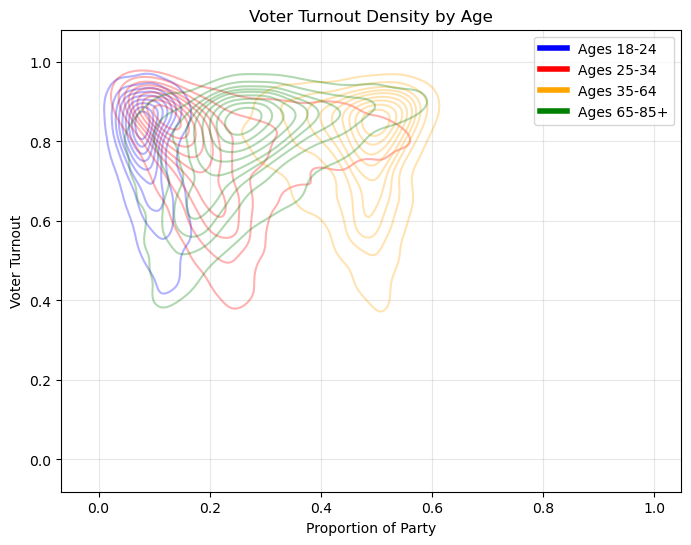

In [ ]:
# Group together age bins for better visualization
X["age_18_24"] = X["age_18_19"]+ X["age_20_24"]
X["age_25_34"] = X["age_25_29"]+ X["age_30_34"]
X["age_35_64"] = X["age_35_44"]+ X["age_45_54"]+ X["age_55_64"]
X["age_65_85over"] = X["age_65_74"]+ X["age_75_84"] + X["age_85over"]

plotKDE(X, 'Voter Turnout Density by Age', 
        ['age_18_24','age_25_34', 'age_35_64', 'age_65_85over'], 
        ['Ages 18-24', 'Ages 25-34',  'Ages 35-64', 'Ages 65-85+'] ,  
        ['blue','red', 'orange', 'green', 'black', 'gray'],
        'Age')

#### DENSITY

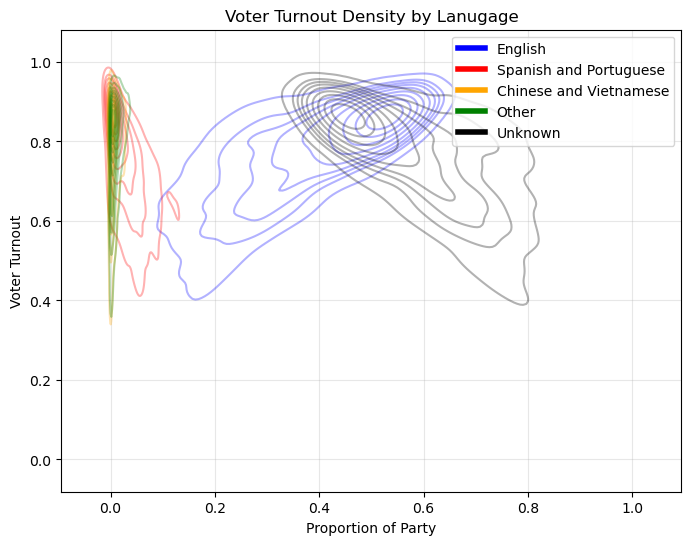

In [ ]:
# Group together spanish+portuguese and vietnamese+chinese for better visualization
X["lang_spanish_portuguese"] =X["lang_spanish"]+X["lang_portuguese"]
X["lang_chinese_vietnamese"] = X["lang_chinese"] + X["lang_vietnamese"]
plotKDE(X, 'Voter Turnout Density by Language',
        ['lang_english','lang_spanish_portuguese','lang_chinese_vietnamese','lang_other', 'lang_unknown'],
        ['English', 'Spanish and Portuguese',  'Chinese and Vietnamese', 'Other', 'Unknown'], 
        ['blue','red', 'orange', 'green', 'black', 'gray'],
        'Language')

## 3. Baseline Model

C:\Users\maxab\AppData\Local\Temp\ipykernel_37848\3858519291.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['total_reg','mean_hh_income']] = StandardScaler().fit_transform(X=X[['total_reg','mean_hh_income']])


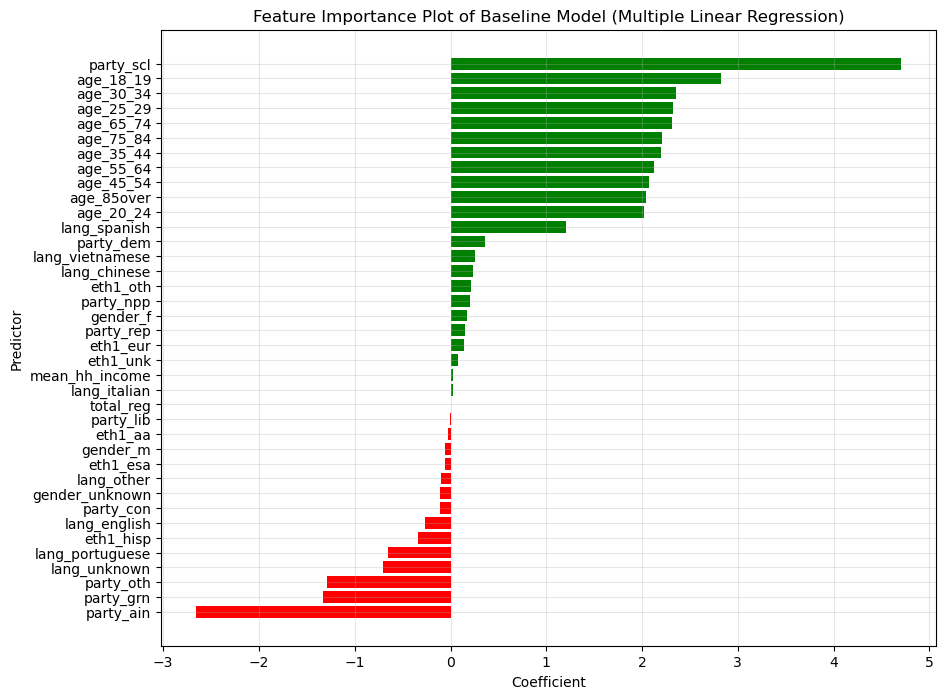

In [14]:
# reduce to just predictors
X = voter_gdf[predictors]
# scale non ratio values
X[['total_reg','mean_hh_income']] = StandardScaler().fit_transform(X=X[['total_reg','mean_hh_income']])
y = voter_gdf['2020_turnout_pct']

# test and train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

# fit model
linreg = LinearRegression().fit(X_train,y_train)

def gatherAndPlotFeatureCoef(model, label):
    # gather pred/coeff results
    preds = []
    coefs = []
    for pred, coef in zip(X.columns,model.coef_):
        preds.append(pred)
        coefs.append(coef)
    coef_df = pd.DataFrame({'Predictor': preds, 'Coefficient':coefs})

    # Visualize coefficients
    # Sort by 'Coefficient' to improve visualization
    coef_df = coef_df.sort_values('Coefficient', ascending=True).reset_index(drop=True)

    # Plot
    plt.figure(figsize=(10, 8))
    colors = coef_df['Coefficient'].apply(lambda x: 'green' if x > 0 else 'red')
    plt.barh(coef_df['Predictor'], coef_df['Coefficient'], color=colors)

    # Add titles and labels
    plt.xlabel('Coefficient')
    plt.ylabel('Predictor')
    plt.title('Feature Importance Plot of Baseline Model '+label)

    # Display plot
    plt.grid(alpha=0.3)
    plt.show()
    return coef_df

coef_df_lr = gatherAndPlotFeatureCoef(linreg,'(Multiple Linear Regression)')

In [15]:
# Report accuracy
y_pred_train = linreg.predict(X_train)
y_pred_test = linreg.predict(X_test)
print("\tTrain\t\tTest")
print(f"MSE\t{mean_squared_error(y_train, y_pred_train):.5f}\t\t{mean_squared_error(y_test, y_pred_test):.5f}")
print(f"R2\t{r2_score(y_train, y_pred_train):.5f}\t\t{r2_score(y_test, y_pred_test):.5f}")

	Train		Test
MSE	0.00215		0.00246
R2	0.82778		0.81028


### LASSO CV

In [16]:
# use CV to select best alpha/lambda value lasso model
lasso_alphas = np.logspace(-4, 0, 1000)
lasso = LassoCV(alphas=lasso_alphas, cv=10, max_iter=1000).fit(X_train, y_train)
lasso_a = lasso.alpha_
print(f'LASSO with alpha={lasso_a:.5f}: {lasso.score(X_test, y_test):.3}')

# fit with CV alpha
cross_lasso_model = Lasso(alpha=lasso_a).fit(X_train, y_train)

# Report accuracy
y_pred_train = cross_lasso_model.predict(X_train)
y_pred_test = cross_lasso_model.predict(X_test)
print("\tTrain\t\tTest")
print(f"MSE\t{mean_squared_error(y_train, y_pred_train):.5f}\t\t{mean_squared_error(y_test, y_pred_test):.5f}")
print(f"R2\t{r2_score(y_train, y_pred_train):.5f}\t\t{r2_score(y_test, y_pred_test):.5f}")

LASSO with alpha=0.00010: 0.798
	Train		Test
MSE	0.00246		0.00261
R2	0.80265		0.79828


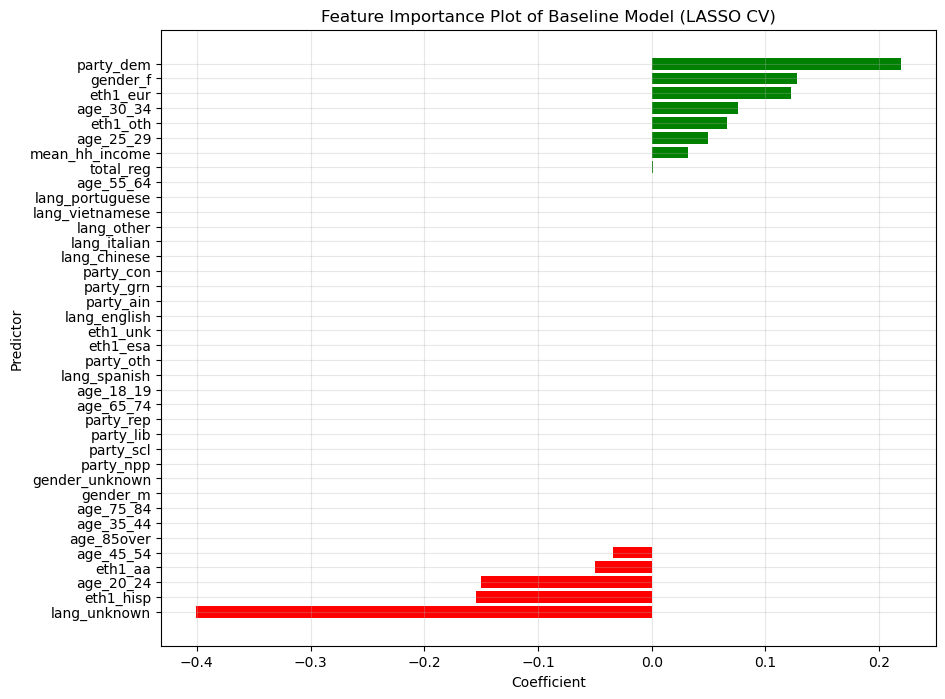

In [17]:
coef_df_lasso = gatherAndPlotFeatureCoef(cross_lasso_model,'(LASSO CV)')

### Permutation Importance

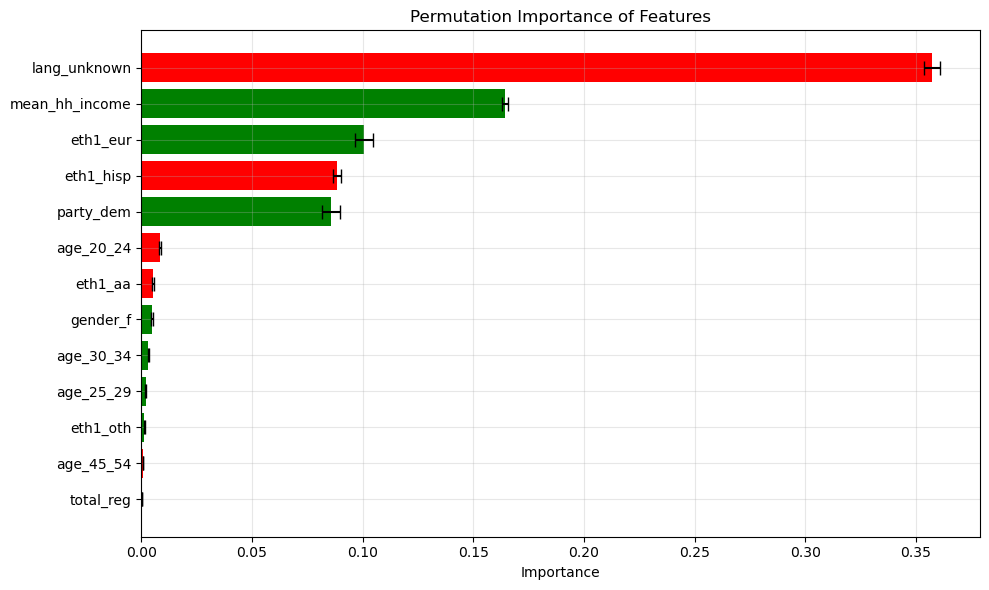

In [18]:
results = permutation_importance(cross_lasso_model, X_train, y_train, n_repeats=5)

# Extract importance scores for each feature
coefs = []
for pred, coef in zip(X_test.columns,cross_lasso_model.coef_):
    coefs.append(coef)

perm_imp = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': results.importances_mean,
    'importance_std': results.importances_std, 
    'betas':coefs
}).sort_values('importance_mean', ascending=False)

perm_imp = perm_imp[perm_imp['importance_mean'] > 0]


F = list(perm_imp['feature'])
I = list(perm_imp['importance_mean'])
E = list(perm_imp['importance_std'])
B = list(perm_imp['betas'])
F.reverse()
I.reverse()
E.reverse()
B.reverse()
colors = ['red' if b < 0 else 'green' for b in B]



# Plot top 10 features with error bars
plt.figure(figsize=(10, 6))


plt.barh(range(len(perm_imp)), I, xerr=E, capsize=5, color=colors)
plt.yticks(range(len(perm_imp)), F)
plt.title('Permutation Importance of Features')
plt.xlabel('Importance')
plt.tight_layout()
plt.grid(alpha=0.3)
plt.show()

 

## 4. Interpret the Results

## 5. Final Model Pipeline